In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from numpy import log
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras import optimizers

import warnings
warnings.filterwarnings("ignore")

C:\Users\chris\anaconda4\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\chris\anaconda4\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\chris\anaconda4\lib\site-packages\numpy\.libs\libopenblas.xwydx2ikjw2nmtwsfyngfuwkqu3lytcz.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# read data
greece_inflation = pd.read_csv('Inflation and Parameters.csv', index_col=0)
greece_inflation.head()

,Cpi,Food Price Index,Energy Price Index,Hicp,Unemployment Rate,Gdp,Rent Price,House Prices,Lci
Date,,,,,,,,,
2001-01-01,0.001806,0.016060,0.111474,0.003837,0.109312,0.000000,0.000000,0.315560,0.000000
2001-02-01,0.000000,0.011688,0.097947,0.000000,0.110324,0.005330,0.006099,0.328415,0.017084
2001-03-01,0.036626,0.008565,0.077760,0.042722,0.110324,0.010660,0.012198,0.341270,0.034167
2001-04-01,0.054424,0.003301,0.082858,0.063443,0.118421,0.015991,0.018297,0.354126,0.051251
2001-05-01,0.062677,0.009190,0.087208,0.072909,0.117409,0.029163,0.025907,0.352209,0.054301


In [7]:
# with the function generate_sequences we create the appropriate sequences for training the model
def generate_sequences(time_series, n_steps):
    sequence, output = list(), list()
    
    for i in range(len(time_series)):

        # n_steps is the number of previous months we use so
         # predict the next month
        window_limit = i + n_steps

        # as soon as we make the last sequence, the function
         # returns the set of sequences
        if window_limit > len(time_series)-1:
            break

        # we store each sequence in a list, which are the input of the model
         # At the same time, we store the target value in a separate list
        input_features, output_features = time_series[i:window_limit], time_series[window_limit]

        sequence.append(input_features)
        output.append(output_features)

        
    return np.asarray(sequence).astype('float32'), np.asarray(output).astype('float32')

In [4]:
# keep only the indexes we want to predict
cols = ['Cpi', 'Hicp']
greece_inflation_pred = greece_inflation.loc[:, greece_inflation.columns.intersection(cols)]
greece_inflation_pred = greece_inflation_pred.apply(pd.to_numeric, errors='coerce')
greece_inflation_pred = greece_inflation_pred.fillna(method='bfill')
greece_inflation_pred.head()

,Cpi,Hicp
Date,,
2001-01-01,0.001806,0.003837
2001-02-01,0.000000,0.000000
2001-03-01,0.036626,0.042722
2001-04-01,0.054424,0.063443
2001-05-01,0.062677,0.072909


In [5]:
# CNN implementation
def CNN():
    preds = []
    tests = []
    
    n_steps = 5
    n_features = 1

    # CNN univariate model
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=n_steps-1, activation='relu', input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # run through our data column by column to predict each index
    for col in greece_inflation_pred.columns:

        # calling the function generate_sequences so that
         # build the sequences that will be piped to the model
        window, output = generate_sequences(greece_inflation_pred[col], n_steps)

        # necessary reshape for the implementation of the model
        window = window.reshape((window.shape[0], window.shape[1], n_features))

        # split the data into train and test
        train_size = int(len(output) * 0.8)
        train_X, test_X = window[0:train_size], window[train_size:]
        train_y, test_y = output[0:train_size], output[train_size:]

        # model split
        model.fit(np.asarray(train_X), np.asarray(train_y), epochs=1000, verbose=0)

        test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))

        # prediction based on test data
        pred = model.predict(test_X, verbose=0)
        
        # creation of the lists of actual and predicted values
        preds.append(pred)
        tests.append(test_y)

        # calculation of error metrics
        mse_ucnn = mean_squared_error(test_y, pred)
        rmse_ucnn = math.sqrt(mean_squared_error(test_y, pred))
        mae_ucnn = mean_absolute_error(test_y, pred)
        mape_ucnn = mean_absolute_percentage_error(test_y, pred)

        print("Univariate CNN MSE for Parameter[" + str(col) + "]:" + str(mse_ucnn))
        print("Univariate CNN RMSE for Parameter[" + str(col) + "]:" + str(rmse_ucnn))
        print("Univariate CNN MAE for Parameter[" + str(col) + "]:" + str(mae_ucnn))

        title = "Univariate CNN for " + "[" + col +"]"

        # creation of the charts of actual and predicted data
        plt.figure(figsize=(20, 5))
        plt.title(title)
        plt.plot(test_y, label='Actual Data', color='blue')
        plt.plot(pred, label='Predicted Data', color='red')
        plt.show()
        
    return preds, tests

Univariate CNN MSE for Parameter[Cpi]:0.0015900416
Univariate CNN RMSE for Parameter[Cpi]:0.03987532520395139
Univariate CNN MAE for Parameter[Cpi]:0.02949427


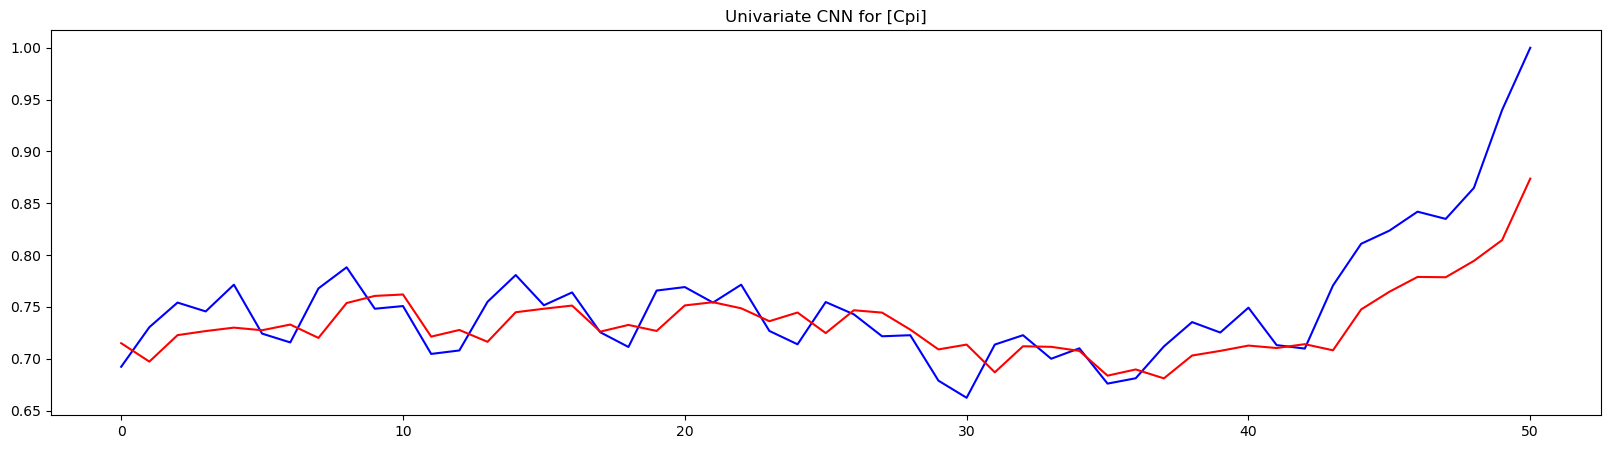

Univariate CNN MSE for Parameter[Hicp]:0.0012608788
Univariate CNN RMSE for Parameter[Hicp]:0.03550885454438662
Univariate CNN MAE for Parameter[Hicp]:0.02630451


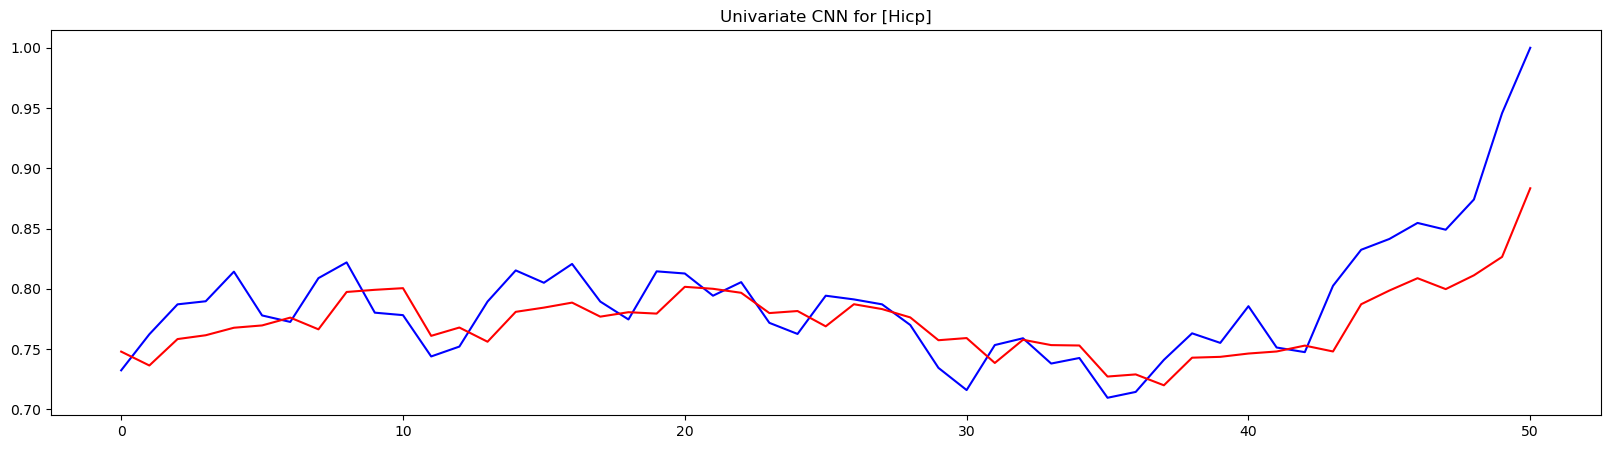

In [6]:
pred_ucnn,test_ucnn = CNN()